# Exercise 4

Authors: Joseph Weibel, Rebecka Fahrni

In [2]:
from scipy.fft import rfft, rfftfreq, irfft
import matplotlib.pyplot as plt
import numpy as np


## Exercise 1a

In [3]:
# load datasets
data = np.load('data/bci_eeg_dataset.npy')
times = np.load('data/bci_eeg_dataset_times.npy')
sampling_freq = 160

print('number of epochs:      ', data.shape[0])
print('number of channels:    ', data.shape[1])
print('number of time samples:', data.shape[2])

number of epochs:       23
number of channels:     3
number of time samples: 961


## Exercise 1b + 1c

In [4]:
def compute_wavelet_transform(signal, n_cycles, sampling_rate, frequencies=np.linspace(1, 40, 40)):
	time_range = np.arange(-1., 1., 1./sampling_rate)

	signal_fft = rfft(signal)

	out = []
	for freq in frequencies:
		sigma_t = n_cycles / (2 * np.pi * freq)
		wavelet = np.exp(2j * np.pi * freq * time_range) * np.exp(-(time_range ** 2) / (2 * (sigma_t ** 2)))
		wavelet = np.real(wavelet / np.abs(wavelet).max()) # ensure max value of wavelet is 1

		# convolve in frequency domain
		wavelet_fft = rfft(wavelet, n=len(signal)) # from time to frequency domain
		result = irfft(signal_fft * wavelet_fft, n=len(signal)) # from frequency to time domain

		power = result[len(wavelet) // 2:-len(wavelet) // 2] ** 2 # adjust size and calculate power
		out.append(power)

	return np.array(out)


(40, 641)


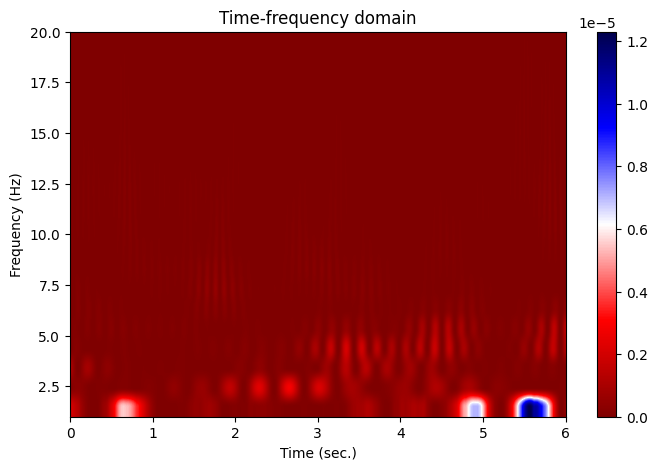

In [5]:
# load test data
test_data = np.load('data/bci_eeg_testData.npy')
frequencies = np.linspace(1, 40, 40)

# compute transform
result = compute_wavelet_transform(test_data, 6, sampling_freq, frequencies)
print(result.shape)

# plot transform
plt.figure(figsize=(8, 5))
plt.imshow(result, aspect='auto', origin='lower', extent=[0, len(test_data) / sampling_freq, frequencies[0], frequencies[-1]], cmap='seismic_r')
plt.title('Time-frequency domain')
plt.xlabel('Time (sec.)')
plt.ylabel('Frequency (Hz)')
plt.ylim(frequencies.min(), frequencies.max() / 2) # adjust y-axis according to the Nyquist theorem
plt.colorbar()
plt.show()

## Exercise 1d

In [6]:
print('Using channel 1/3')
channel_data = data[:, 0, :] # use channel 0

results = []
for epoch_data in channel_data:
	power = compute_wavelet_transform(epoch_data, 6, sampling_freq, frequencies)

	# normalize with baseline
	delta = (epoch_data.shape[0] - power.shape[1]) // 2 # calculate difference between size of signal and time points
	baseline_mean = power[:, times[delta:-delta] < 0].mean(axis=1, keepdims=True)
	normalized_power = (power - baseline_mean) / baseline_mean
	results.append(normalized_power)

results = np.array(results)
results.shape

Using channel 1/3


(23, 40, 641)

## Exercise 1e

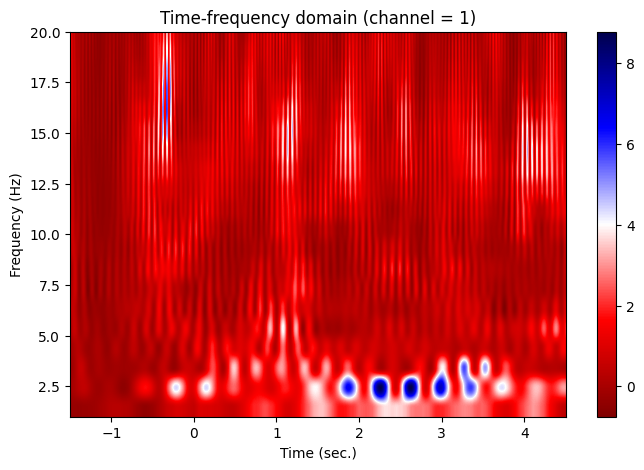

In [7]:
# average over epochs
avg_results = results.mean(axis=0)

# plot transform
plt.figure(figsize=(8, 5))
plt.imshow(avg_results, aspect='auto', origin='lower', extent=[-(times < 0).sum() / sampling_freq, (times >= 0).sum() / sampling_freq, frequencies[0], frequencies[-1]], cmap='seismic_r')
plt.title('Time-frequency domain (channel = 1)')
plt.xlabel('Time (sec.)')
plt.ylabel('Frequency (Hz)')
plt.ylim(frequencies.min(), frequencies.max() / 2) # adjust y-axis according to the Nyquist theorem
plt.colorbar()
plt.show()

## Exercise 1f

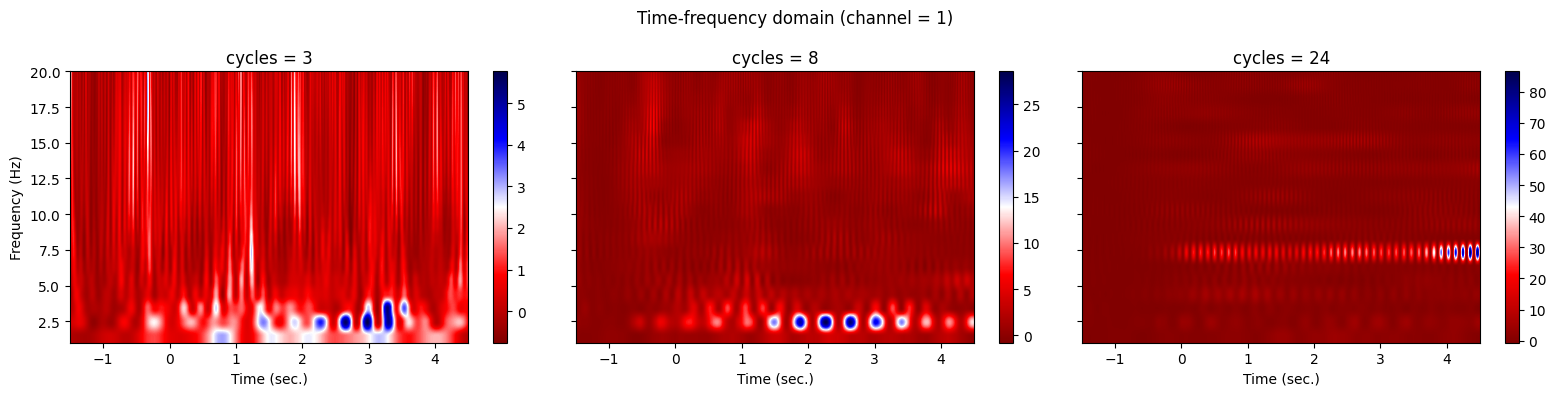

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
for i, n_cycles in enumerate([3, 8, 24]):
	results = []
	for epoch_data in channel_data:
		power = compute_wavelet_transform(epoch_data, n_cycles, sampling_freq, frequencies)

		# normalize with baseline
		delta = (epoch_data.shape[0] - power.shape[1]) // 2 # calculate difference between size of signal and time points
		baseline_mean = power[:, times[delta:-delta] < 0].mean(axis=1, keepdims=True)
		normalized_power = (power - baseline_mean) / baseline_mean
		results.append(normalized_power)

	results = np.array(results)
	avg_results = results.mean(axis=0)

	# plot individual subplot
	im = axs[i].imshow(avg_results, aspect='auto', origin='lower', extent=[-(times < 0).sum() / sampling_freq, (times >= 0).sum() / sampling_freq, frequencies[0], frequencies[-1]], cmap='seismic_r')
	axs[i].set_ylim(frequencies.min(), frequencies.max() / 2) # adjust y-axis according to the Nyquist theorem
	axs[i].set_title(f'cycles = {n_cycles}')
	axs[i].set_xlabel('Time (sec.)')
	fig.colorbar(im, ax=axs[i])

# plot settings for all subplots
plt.suptitle('Time-frequency domain (channel = 1)')
axs[0].set_ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()